In [23]:
from Beamformer_MVDR import beamformer_MVDR
import utils
from acoular import MicGeom
import numpy as np

# Parameters

# H5FILENAME = '/media/xian/Data/dataset/Bekaert/h5files/42.h5'
H5FILENAME = 'mix_sine.h5'
H5FILENAME2 = 'noise_sine.h5'

OUTPUT_FILENAME = 'enhanced_audio.wav'

mg = MicGeom(from_file='array_9.xml')
number_of_mic = mg.mpos.shape[1]
MIC_POS = []
for i in np.arange(number_of_mic):
    MIC_POS.append(mg.mpos[:,int(i)])

LOOK_POS = [0, 2, 0.5]
SAMPLING_RATE = 51200
FFT_LENGTH = 512
FFT_SHIFT = 256
SOUND_SPEED = 343

In [24]:
multi_signal = utils.get_data_from_h5(H5FILENAME, skip_last_channel=False)
noise_signal = utils.get_data_from_h5(H5FILENAME2, skip_last_channel=False)

mvdr_beamformer = beamformer_MVDR(MIC_POS, sampling_rate=SAMPLING_RATE, fft_length=FFT_LENGTH, fft_shift=FFT_SHIFT, sound_speed=SOUND_SPEED)

steering_vector = mvdr_beamformer.get_steering_vector_near_field(LOOK_POS)

spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(noise_signal) # noise covariance matrix

beamformer = mvdr_beamformer.get_mvdr_beamformer(steering_vector, spatial_correlation_matrix)

complex_spectrum = utils.get_spectrogram(multi_signal, FFT_LENGTH, FFT_LENGTH, FFT_LENGTH) # no overlap, no window, for ifft

enhanced_spectrum = mvdr_beamformer.apply_beamformer(beamformer, complex_spectrum)

Calculating result for 4007.8277886497062Hz


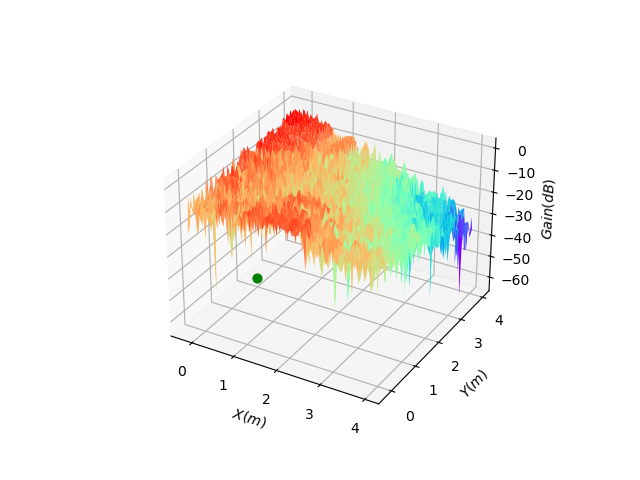

In [27]:
%matplotlib widget
from acoular import RectGrid
import matplotlib.pyplot as plt

"""
define grid
"""
rg = RectGrid( x_min=-0.2, x_max=4,
                        y_min=-0.2, y_max=4,
                        z=1, increment=0.05 )

grid_points = int(np.sqrt(rg.gpos.shape[1]))

frequency = 4000

filter = mvdr_beamformer.get_filter(rg, beamformer, frequency)

"""
plot beamformer
"""
fig = plt.figure()
ax3 = plt.axes(projection='3d')

X_g = rg.gpos[0,:].reshape(grid_points,grid_points)
Y_g = rg.gpos[1,:].reshape(grid_points,grid_points)
Z_g = 20 * np.log10(filter.reshape(grid_points,grid_points))
# Z_g = filter.reshape(grid_points,grid_points)

# ax3.scatter(noise_coord[0], noise_coord[1], np.min(Z_g), s=40, c='r', marker='x')
ax3.scatter(LOOK_POS[0], LOOK_POS[1], np.min(Z_g), s=40, c='g', marker='o')

ax3.set_xlabel('$X (m)$')
ax3.set_ylabel('$Y (m)$')
ax3.set_zlabel('$Gain (dB)$')

ax3.plot_surface(X_g,Y_g,Z_g,cmap='rainbow')
#ax3.contour(X,Y,Z, zdim='z',offset=-2，cmap='rainbow)   #等高线图，要设置offset，为Z的最小值
plt.show()

In [26]:
from scipy.io.wavfile import write

enhanced_audio = utils.spec2wav(enhanced_spectrum, SAMPLING_RATE, FFT_LENGTH, FFT_LENGTH, FFT_LENGTH)

enhanced_audio = enhanced_audio / np.max(np.abs(enhanced_audio)) * 0.7

write(OUTPUT_FILENAME, SAMPLING_RATE, enhanced_audio.astype(np.float32))
write('enhanced_audio_best_mic.wav', SAMPLING_RATE, multi_signal[:,7].astype(np.float32))
write('enhanced_audio_worst_mic.wav', SAMPLING_RATE, multi_signal[:,1].astype(np.float32))